In [1]:
import json, os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import numpy as np

test_name = 'neuroM_morph_softChecks'
model_results = 'population_models_excerpt-pop/20191219-163146'
val_results_dir='./validation_results'
val_results_path = os.path.join(val_results_dir, test_name, model_results)

if not os.path.exists(val_results_path):
    os.makedirs(val_results_path)
    
pred_file_path = os.path.join(val_results_path,'prediction_summary_FSI_pop.json')
with open(pred_file_path, 'r') as fp:
    pop_prediction_raw = json.load(fp)

In [2]:
prediction_raw = pop_prediction_raw.values()[0]

dict_pred_CellPart_df = dict()
for CellPart in prediction_raw.keys():
    dict_pred_CellPart_df[CellPart] = pd.DataFrame(prediction_raw[CellPart])

In [3]:
def corrfunc(x, y, **kws):
    r,p = stats.pearsonr(x,y)
    ax = plt.gca()
    ax.annotate("r = {:.2E}\n(p ={:.2E})".format(r,p),
                xy=(.1, .9), xycoords=ax.transAxes)

In [4]:
def df_drop_features(df=None, threshold_corr=0.95, threshold_var=0.05):
    '''Drops one in any pair of highly correlated features of a DataFrame, 
    as the calculation of some quantities may not be posible. Besides, 
    columns with no variance are excluded. For instance,
    joint kernel distributions estimates (kde) for two highly correlated 
    features may not be computed. The same holds for features with low variability.
    
    The cutoffs for correlation (or variance) to be considered as too high (or too low)
    are given by 'threshold_corr' ('threshold_var'). 
    
    Note: Adapted from 
    https://chrisalbon.com/machine_learning/feature_selection/
    drop_highly_correlated_features/  
    '''
    
    feats_to_drop = list()
    # Compute the correlation DataFrame of the original DataFrame of feature values
    corr_matrix_df = df.corr().abs()
    # Build a copy with the elements below the first diagonal as False
    upper = corr_matrix_df.where(np.triu(np.ones(corr_matrix_df.shape), k=1).astype(np.bool))
    # Find and collect one feature name in any pair of correlated features 
    features_hcorr = [column for column in df.columns 
                      if any(upper[column] > threshold_corr)]
    feats_to_drop.extend(features_hcorr) 

    # Compute the variance DataSeries of the original DataFrame of feature values
    var_series = df.var().abs() 
    # Find and collect all features with low variance
    feats_no_var= [column for column in df.columns 
                   if var_series[column] < threshold_var]
    feats_to_drop.extend(feats_no_var) 
    
    # Drop all those disposable (maybe superfluous) features found
    df.drop(df[feats_to_drop], axis=1, inplace=True)
    
    return df

/home/pedroernesto/miniconda2/envs/BasalGanglia/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


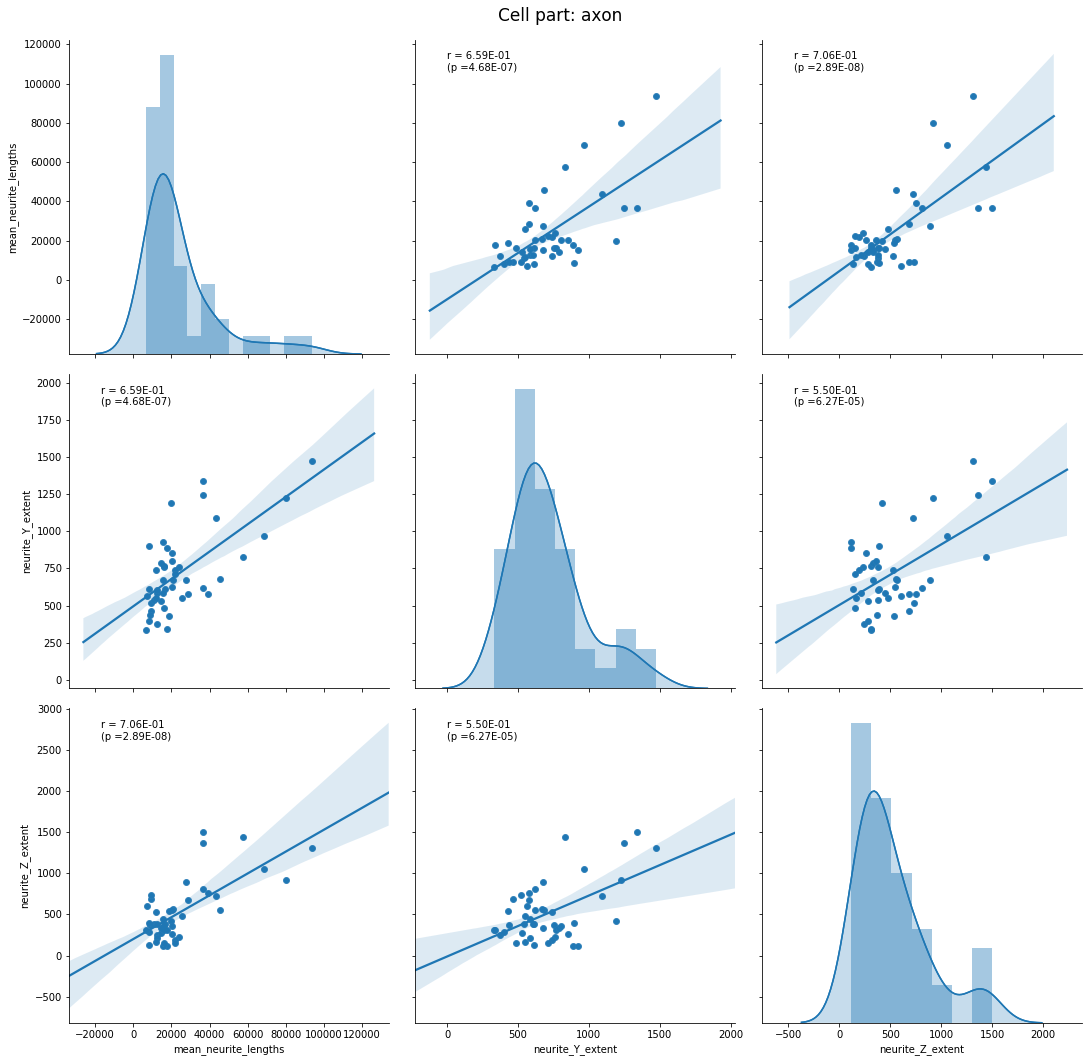

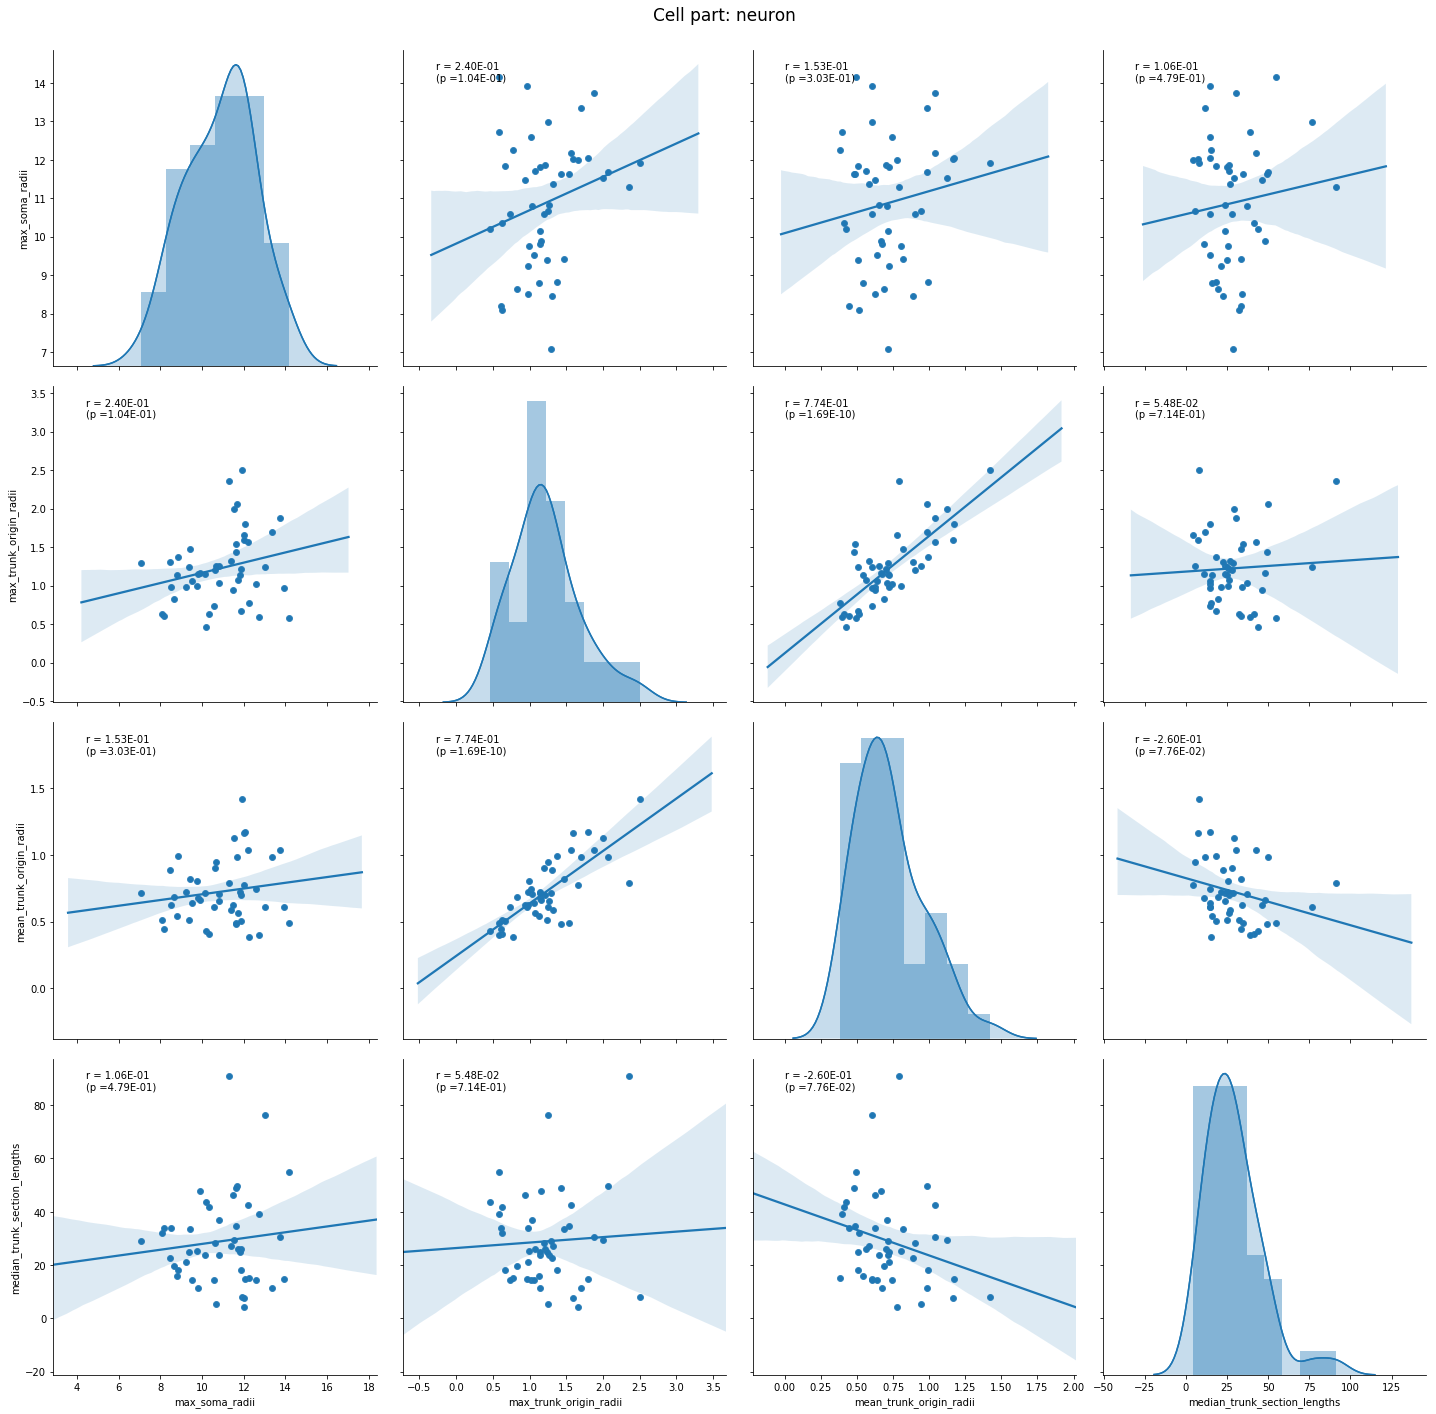

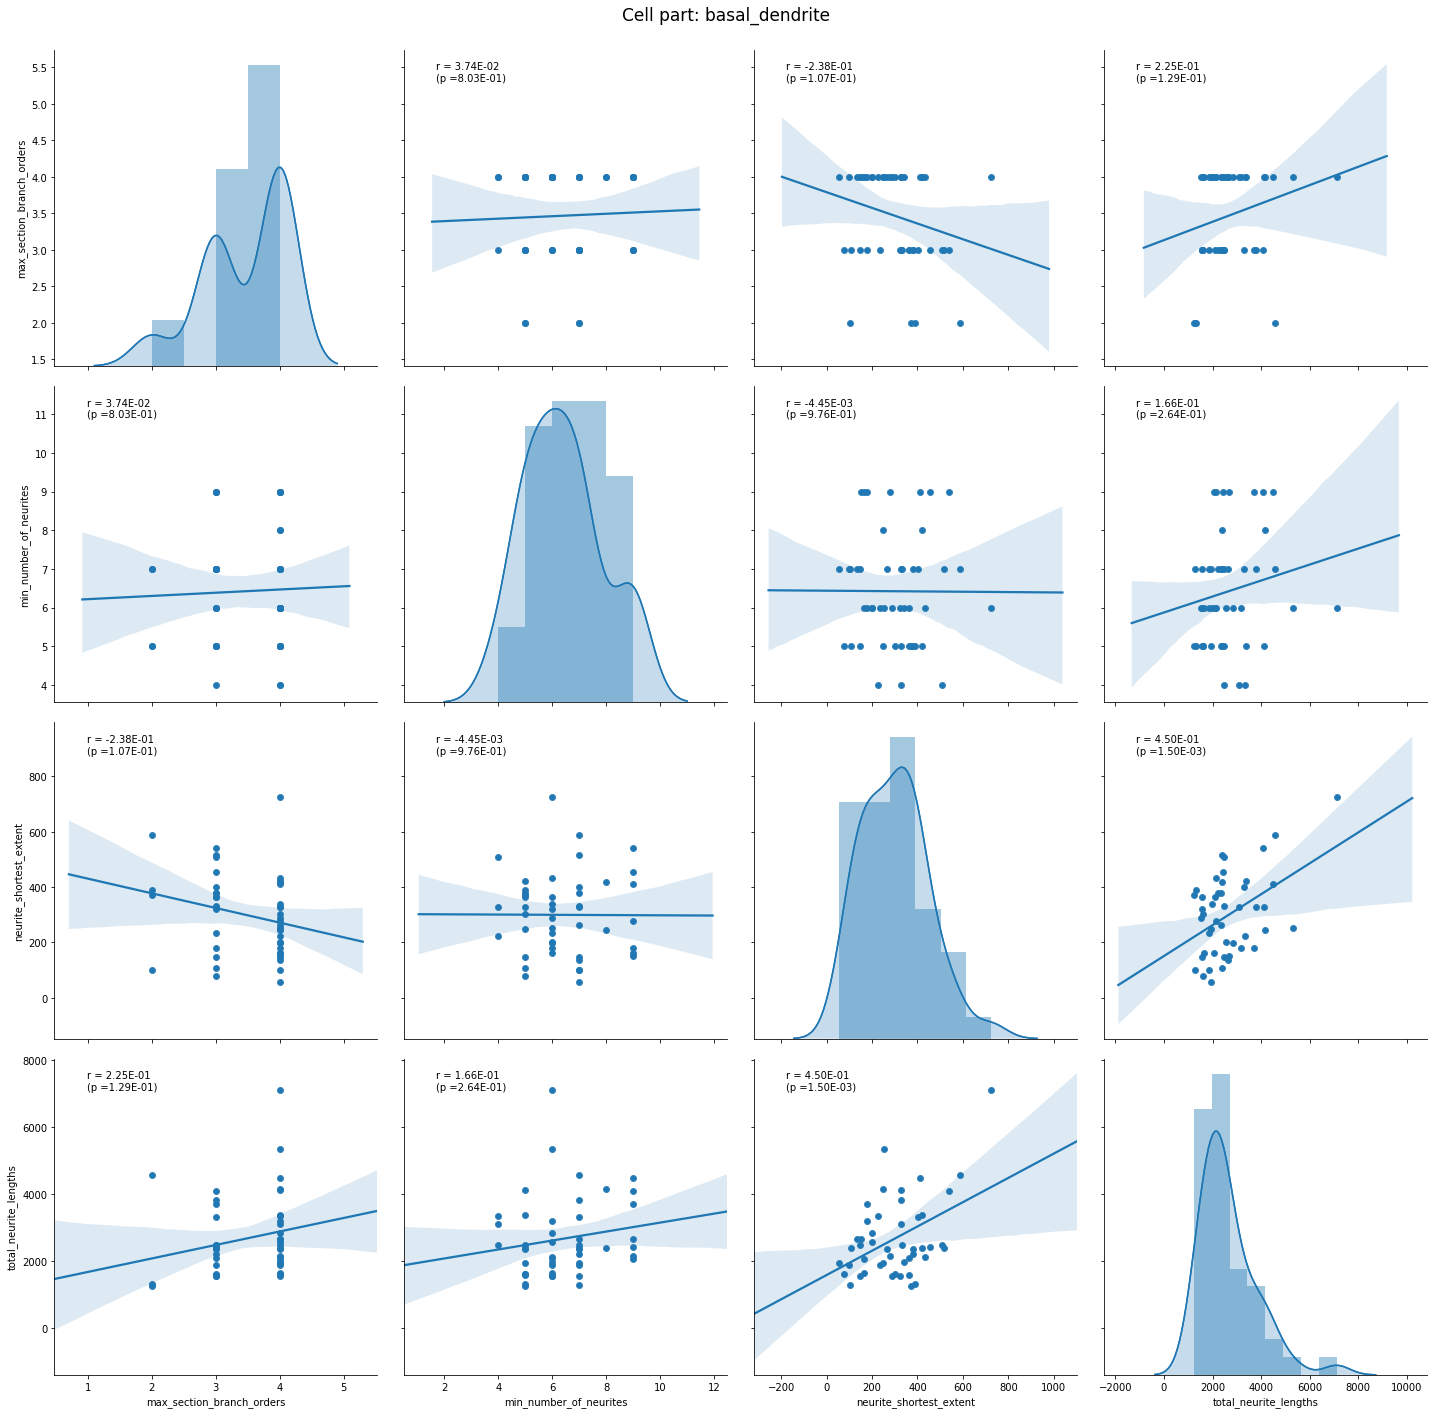

In [5]:
for CellPart, prediction_raw_df in dict_pred_CellPart_df.items():
    data = df_drop_features(df=prediction_raw_df)

    g = sns.pairplot(data, height=5, aspect=1, diag_kind="kde")
    # g = sns.PairGrid(data, size=5, aspect=1, palette=["red"])
    # g.map(sns.regplot)
    # g.map(corrfunc)
    g.map_upper(sns.regplot)
    g.map_upper(corrfunc)
    g.map_diag(sns.distplot, kde=True)
    g.map_lower(sns.regplot)
    g.map_lower(corrfunc)
    
    plt.subplots_adjust(top=0.95)
    g.fig.suptitle('Cell part: '+CellPart, fontsize=17) 

    filepath = os.path.join(val_results_path,'prediction_lreg_'+CellPart+'_FSI_pop.pdf')
    # plt.savefig(filepath, dpi=600, )

axon --> Index([u'mean_neurite_lengths', u'neurite_Y_extent', u'neurite_Z_extent'], dtype='object') 

neuron --> Index([u'max_soma_radii', u'max_trunk_origin_radii',
       u'mean_trunk_origin_radii', u'median_trunk_section_lengths'],
      dtype='object') 

basal_dendrite --> Index([u'max_section_branch_orders', u'min_number_of_neurites',
       u'neurite_shortest_extent', u'total_neurite_lengths'],
      dtype='object') 



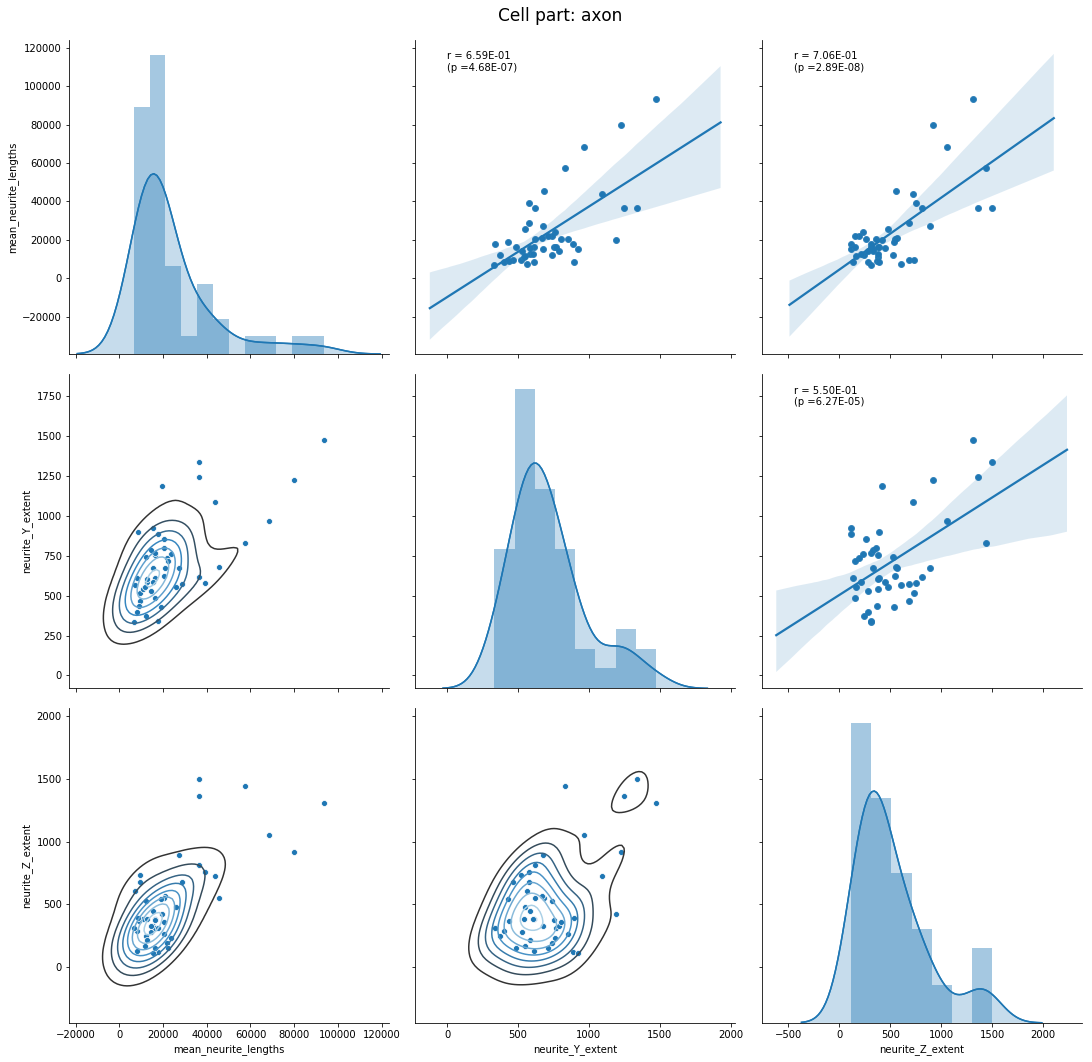

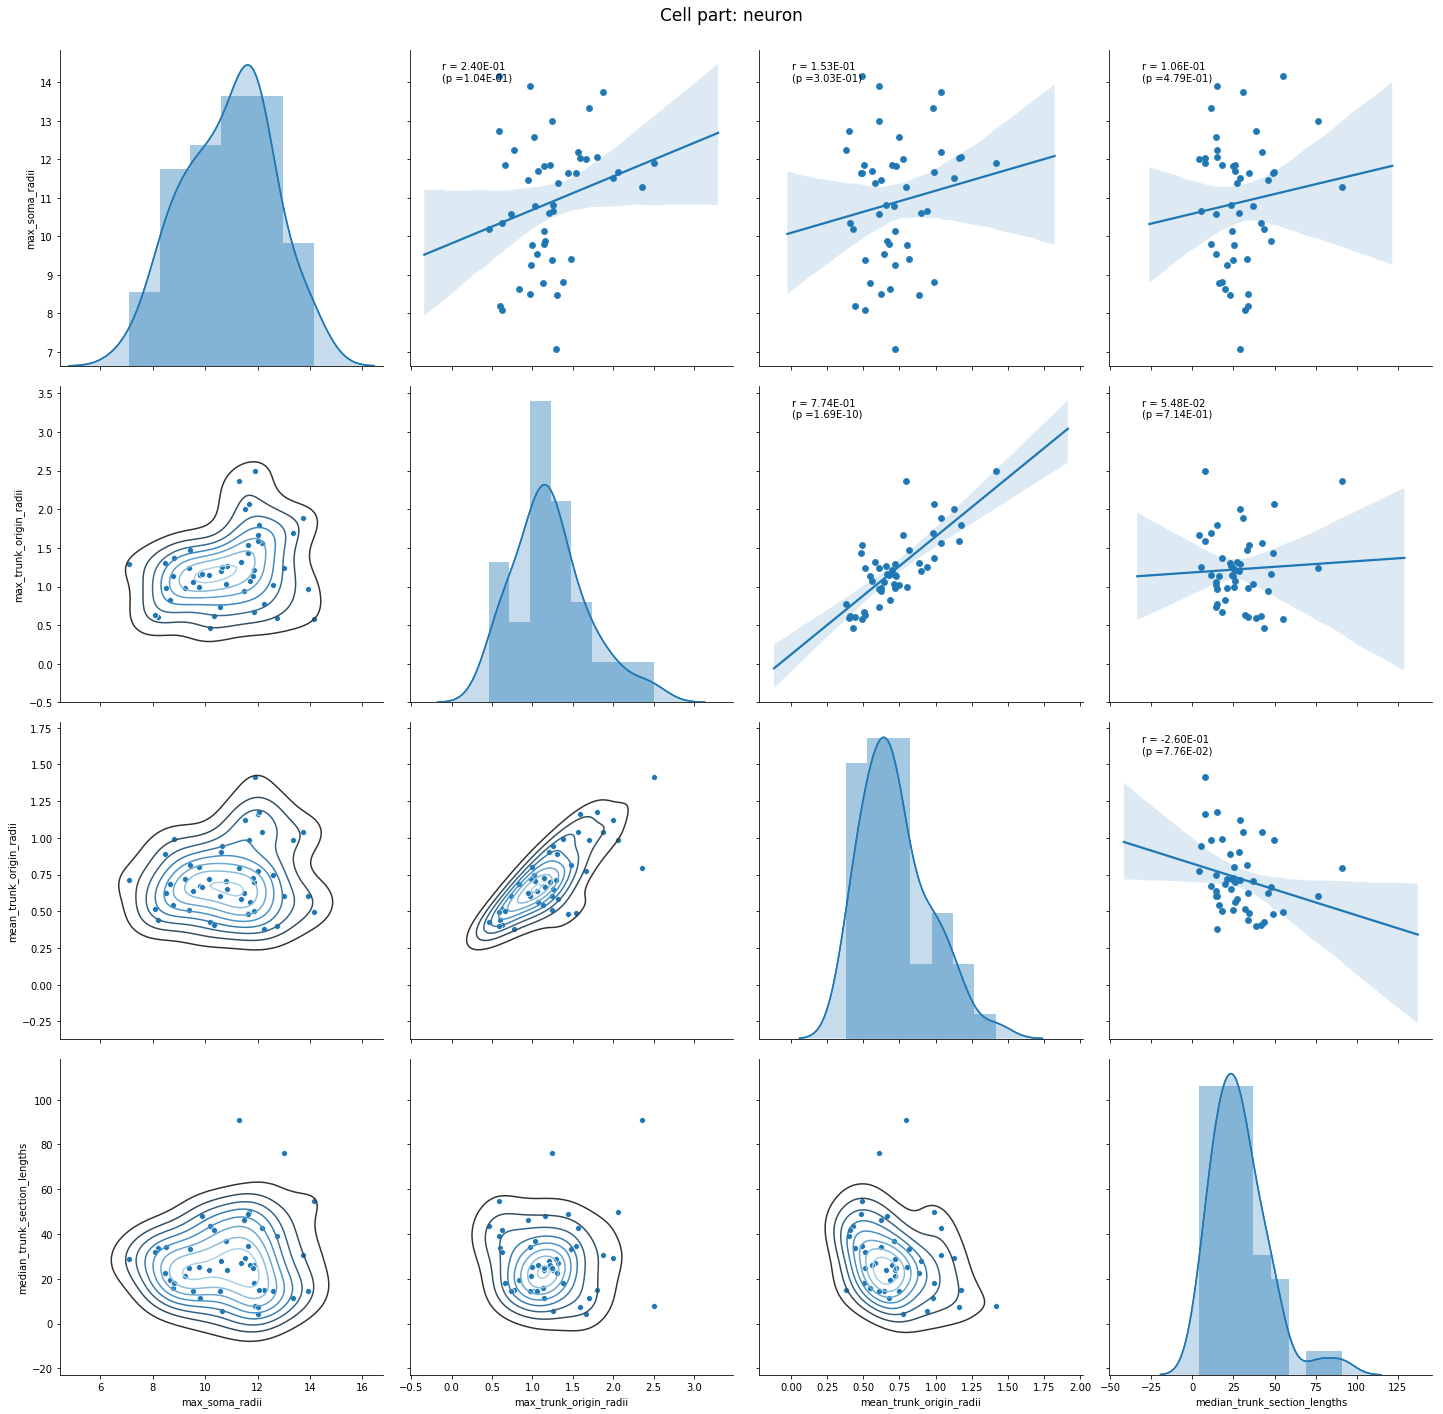

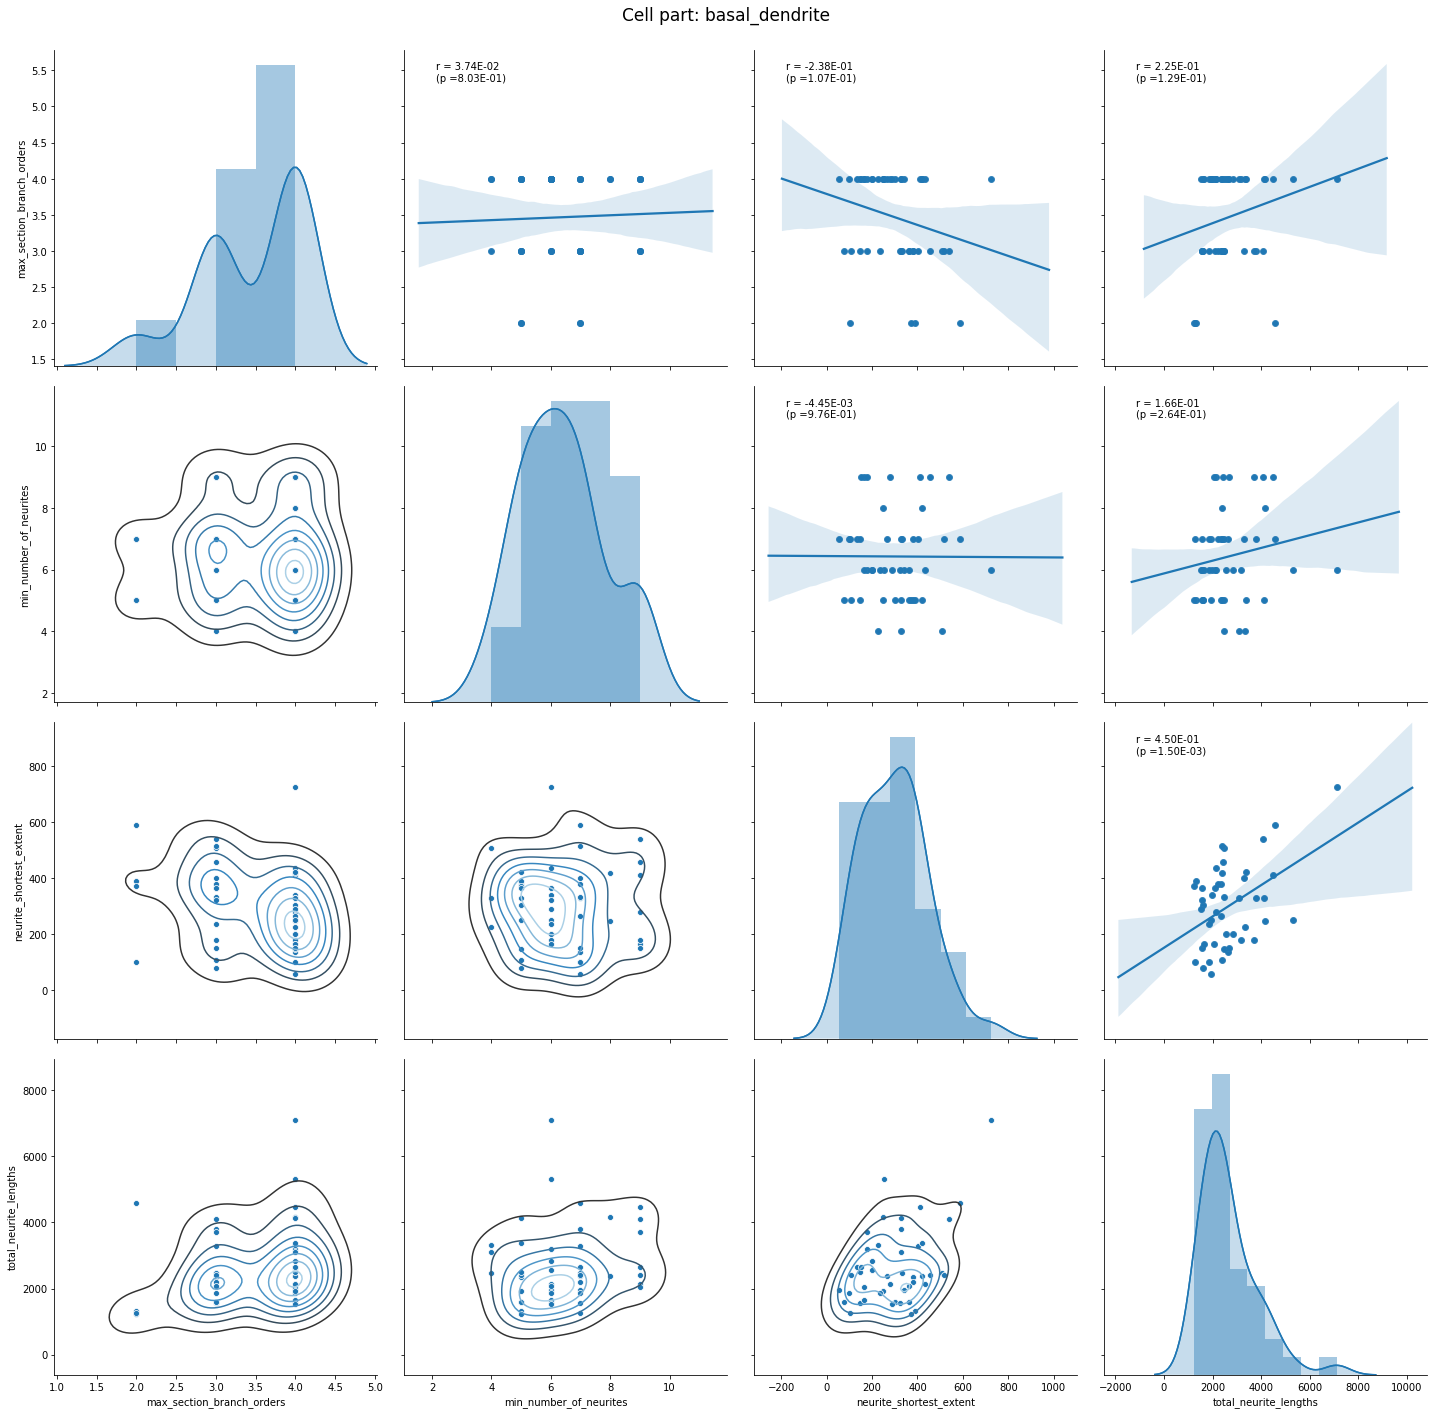

In [6]:
for CellPart, prediction_raw_df in dict_pred_CellPart_df.items():
    data = df_drop_features(df=prediction_raw_df)
    
    print CellPart, '-->', data.columns, '\n'
    g = sns.pairplot(data, height=5, aspect=1, diag_kind="kde")
    # g = sns.PairGrid(data, size=5, aspect=1, palette=["red"])
    g.map_upper(sns.regplot)
    g.map_upper(corrfunc)
    # g.map_upper(plt.reg, s=10)
    g.map_diag(sns.distplot, kde=True)
    g.map_lower(sns.kdeplot, cmap="Blues_d", n_levels=8)
    
    plt.subplots_adjust(top=0.95)
    g.fig.suptitle('Cell part: ' + CellPart, fontsize=17) 
    
    filepath = os.path.join(val_results_path,'prediction_stats__'+CellPart+'_FSI_pop.pdf')
    # plt.savefig(filepath, dpi=600, )